In [280]:
import sys
sys.path.insert(0, '../frameaxis')
from semaxis import CoreUtil
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import pickle

# Análisis de variaciones del sesgo y la intensidad entre artículos y su resumen

## Función para obtener los top N microframes con mayor variación

In [281]:
def top_n_microframe_var(
    tsv_body_path, 
    tsv_summary_path,
    reverse=False,
    n=10
):
    # Cargar los archivos TSV
    df_body = pd.read_csv(tsv_body_path, sep="\t", dtype={'uri': str})
    df_summary = pd.read_csv(tsv_summary_path, sep="\t", dtype={'uri': str})

    # Merge directo por 'uri'
    merged = pd.merge(df_body, df_summary, on="uri", suffixes=("_body", "_summary"))
    microframes = [col for col in df_body.columns if col != "uri"]

    # Vectorizado: calcular diferencias para todas las columnas a la vez
    body_cols = [f"{mf}_body" for mf in microframes]
    summary_cols = [f"{mf}_summary" for mf in microframes]
    diff = merged[summary_cols].values - merged[body_cols].values
    if 'intensity' in tsv_body_path:
        # Evitar división por cero
        with np.errstate(divide='ignore', invalid='ignore'):
            diff = np.where(merged[body_cols].values != 0, diff / merged[body_cols].values, np.nan)

    # Reestructurar a formato largo (long-form) usando numpy y pandas
    n_rows = merged.shape[0]
    data = {
        'uri': np.repeat(merged['uri'].values, len(microframes)),
        'microframe': np.tile(microframes, n_rows),
        'diff': diff.flatten(),
        'body': merged[body_cols].values.flatten(),
        'summary': merged[summary_cols].values.flatten()
    }
    df_long = pd.DataFrame(data)
    
    # Ordenar y devolver top n
    top = df_long.sort_values('diff', ascending=not reverse).head(n)
    return top.reset_index(drop=True)

## Funciones para graficar las variaciones

In [282]:
def plot_diff(data, model_name, diff_type):
    fig, ax = plt.subplots(figsize=(8, 5))

    xmin, xmax = -0.2, 0.2  # Rango del eje x
    for index, row in data.iterrows():
        y = -index

        # Línea horizontal de referencia
        ax.hlines(y, xmin, xmax, color='blue', lw=0.7, alpha=0.2)

        # Flecha entre los dos puntos
        ax.annotate(
            '', xy=(row['summary'], y), xytext=(row['body'], y),
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5),
            zorder=1,
        )
        #ax.plot([row['body'], row['summary']], [y, y], color='black', lw=1.5)

        # Puntos: grupo 1 (azul), grupo 2 (rojo)
        ax.plot(row['body'], y, 'o', color='tab:blue', label='Artículo original' if index == 0 else "")
        ax.plot(row['summary'], y, 'o', color='tab:orange', label=f'Resumen de {model_name}' if index == 0 else "")

        # Palabras izquierda y derecha
        microframe = ast.literal_eval(row['microframe'])
        ax.text(xmin - 0.005, y, f"{microframe[0]}", ha='right', va='center')
        ax.text(xmax + 0.005, y, f"{microframe[1]}", ha='left', va='center')

    # Configuración del gráfico
    ax.axvline(0, color='black', linestyle='--', lw=1)
    ax.set_xlim(xmin - 0.02, xmax + 0.02)
    ax.set_ylim(-len(data), 1)
    ax.set_yticks([])
    ax.set_xlabel('Sesgo')
    ax.set_title(f'Microframes con mayor variación {diff_type} del sesgo en resúmenes de {model_name}', fontsize=14, pad=40)

    # Estética
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.125))

    plt.tight_layout()
    plt.savefig(f"./plots/{model_name}-bias-var-{diff_type}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

In [283]:
def plot_intensity_diff(data, model_name, diff_type):
    # Número de variables
    y_pos = np.arange(len(data['microframe']))

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Agregar las barras horizontales
    ax.barh(y_pos - 0.15, data['body'], height=0.3, label='Artículo original', align='center')
    ax.barh(y_pos + 0.15, data['summary'], height=0.3, label=f'Resumen de {model_name}', align='center')

    # Configurar el eje Y
    ax.set_yticks(y_pos)
    ax.set_yticklabels(data['microframe'])
    ax.invert_yaxis()  # Para que la primera etiqueta esté arriba

    # Agregar líneas de referencia y leyenda
    ax.axvline(x=0, color='gray', linestyle='--')  # Línea vertical en 0
    ax.legend()

    # Configurar etiquetas y título
    ax.set_xlabel('Intensidad')
    ax.set_title(f'Microframes con mayor variación {diff_type} de la intensidad en resúmenes de {model_name}')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.savefig(f"./plots/{model_name}-intensity-var-{diff_type}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

## Función para graficar las palabras con mayor contribución a un microframe

In [284]:
def plot_word_contribution(data_body, data_summary, microframe, filename, model_name, type):
    # Número de variables
    y_pos = np.arange(len(data_body['contribution']))

    # Crear el gráfico
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    data_list = [data_body, data_summary]
    for i in range(2):
        xmin, xmax = -data_list[i]['abs_contribution'].max(), data_list[i]['abs_contribution'].max()
        if type == 'intensity':
            xmin = 0

        # Agregar las barras horizontales
        axes[i].barh(y_pos, data_list[i]['contribution'], color = 'tab:blue' if i == 0 else 'tab:orange', height=0.3, align='center')

        # Configurar el eje Y
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(data_list[i]['word'])
        axes[i].invert_yaxis()  # Para que la primera etiqueta esté arriba

        # Agregar líneas de referencia y leyenda
        axes[i].axvline(x=0, color='gray', linestyle='--')  # Línea vertical en 0
        axes[i].set_xlim(xmin - 0.0005 if xmin != 0 else xmin, xmax + 0.0005)

        # Configurar etiquetas y título
        axes[i].set_xlabel('Contribución')
        axes[i].set_title('Artículo original' if i == 0 else f'Resumen de {model_name}')

        if type == 'bias':
            # Palabra a la izquierda
            axes[i].text(0.1, 0.49, ast.literal_eval(microframe)[0],
                    color='black', ha='left', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'),
                    transform=axes[i].transAxes)
            
            # Palabra a la derecha
            axes[i].text(0.9, 0.49, ast.literal_eval(microframe)[1],
                    color='black', ha='right', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'),
                    transform=axes[i].transAxes)
    
    sup_title = f'Palabras con mayor contribución al sesgo del microframe {microframe}' if type == 'bias' else f'Palabras con mayor contribución a la intensidad del microframe {microframe}'
    fig.suptitle(sup_title)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.savefig(f"./plots/word-contributions/word-contrib-{filename}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

## Top microframes para los resúmenes generados con GPT

### Top 5 variaciones positivas y negativas del sesgo

In [285]:
gpt_bias_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_gpt_summaries.tsv',
    reverse=True,
    n=5
)
gpt_bias_pos

,uri,microframe,diff,body,summary
0,7159524639,"('contento', 'descontento')",0.108225,-0.064975,0.043251
1,7192834783,"('gracioso', 'solemne')",0.099020,-0.043991,0.055028
2,7192834783,"('divertido', 'solemne')",0.095053,-0.045777,0.049276
3,7310662898,"('cortés', 'descortés')",0.092376,-0.136277,-0.043900
4,7161985167,"('bueno', 'triste')",0.089935,0.010938,0.100873


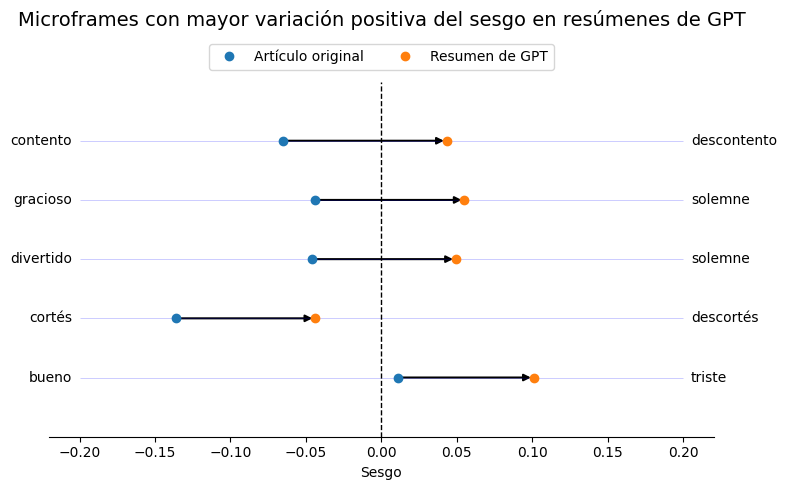

In [286]:
plot_diff(gpt_bias_pos, "GPT", "positiva")

In [287]:
gpt_bias_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_gpt_summaries.tsv',
    reverse=False,
    n=5
)
gpt_bias_neg

,uri,microframe,diff,body,summary
0,7161985167,"('insuficiente', 'suficiente')",-0.105595,0.060010,-0.045585
1,6974345343,"('insuficiente', 'suficiente')",-0.101845,-0.001611,-0.103456
2,6972186557,"('insuficiente', 'suficiente')",-0.087754,0.031237,-0.056517
3,7310662898,"('afilado', 'romo')",-0.087076,0.155203,0.068127
4,6918169523,"('comparativo', 'perfecto')",-0.084824,0.046472,-0.038352


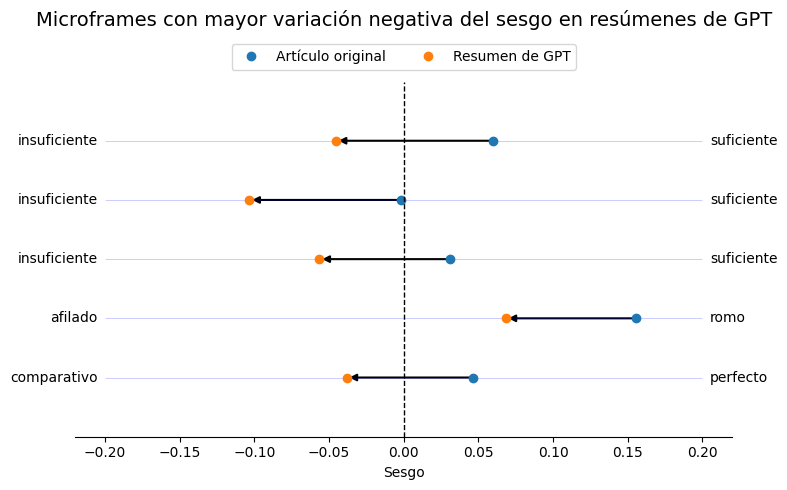

In [288]:
plot_diff(gpt_bias_neg, "GPT", "negativa")

### Top 5 variaciones positivas y negativas de la intensidad

In [289]:
gpt_intensity_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_gpt_summaries.tsv',
    reverse=True,
    n=5
)
gpt_intensity_pos

,uri,microframe,diff,body,summary
0,6897337010,"('negativo', 'neutral')",7.354932,0.001576,0.013168
1,7192252568,"('alto', 'bajo')",6.481791,0.001276,0.009549
2,7128661525,"('dentro', 'fuera')",6.261001,0.004104,0.029799
3,7108688795,"('futuro', 'presente')",6.199119,0.003094,0.022275
4,7118182046,"('común', 'excepcional')",5.797802,0.002344,0.015933


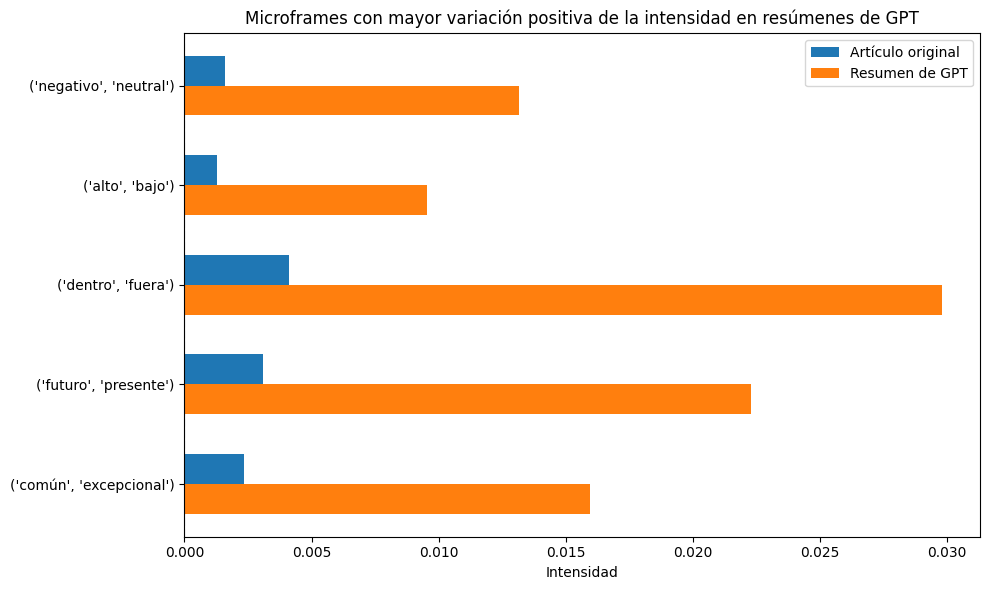

In [290]:
plot_intensity_diff(gpt_intensity_pos, "GPT", "positiva")

In [291]:
gpt_intensity_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_gpt_summaries.tsv',
    reverse=False,
    n=5
)
gpt_intensity_neg

,uri,microframe,diff,body,summary
0,7159517387,"('alto', 'corto')",-0.878481,0.007098,0.000863
1,6972186557,"('grande', 'pequeño')",-0.855577,0.011404,0.001647
2,7169214651,"('agudo', 'bajo')",-0.854133,0.013423,0.001958
3,7178474254,"('menos', 'más')",-0.852234,0.008411,0.001243
4,7169214651,"('ningún', 'todo')",-0.851446,0.009543,0.001418


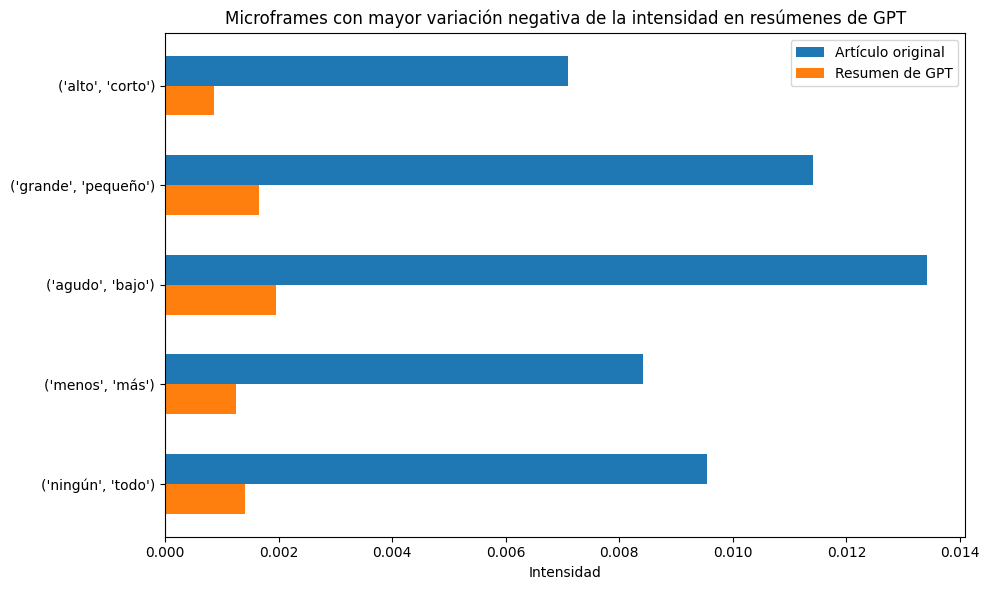

In [292]:
plot_intensity_diff(gpt_intensity_neg, "GPT", "negativa")

## Top microframes para los resúmenes generados con Claude

### Top 5 variaciones positivas y negativas del sesgo

In [293]:
claude_bias_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_claude_summaries.tsv',
    reverse=True,
    n=5
)
claude_bias_pos

,uri,microframe,diff,body,summary
0,7310662898,"('cortés', 'descortés')",0.108114,-0.136277,-0.028163
1,7180096522,"('contento', 'descontento')",0.100001,-0.028742,0.071258
2,7192834783,"('gracioso', 'solemne')",0.095186,-0.043991,0.051195
3,7192834783,"('divertido', 'solemne')",0.094099,-0.045777,0.048322
4,7310662898,"('cortés', 'grosero')",0.091268,-0.139247,-0.047979


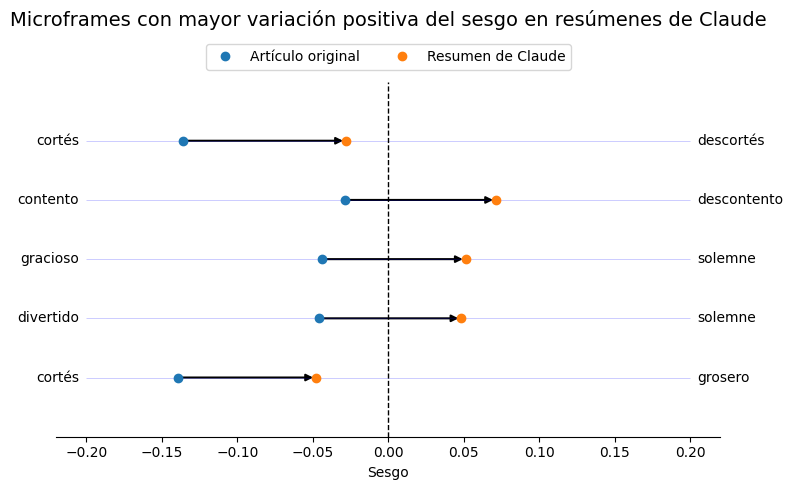

In [294]:
plot_diff(claude_bias_pos, "Claude", "positiva")

In [295]:
claude_bias_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_claude_summaries.tsv',
    reverse=False,
    n=5
)
claude_bias_neg

,uri,microframe,diff,body,summary
0,7297062407,"('cortés', 'grosero')",-0.120818,0.014717,-0.106102
1,7297062407,"('cortés', 'descortés')",-0.118561,0.025288,-0.093273
2,7161985167,"('insuficiente', 'suficiente')",-0.106285,0.060010,-0.046275
3,6918169523,"('eficaz', 'inútil')",-0.100634,0.017356,-0.083277
4,7310662898,"('afilado', 'romo')",-0.095225,0.155203,0.059979


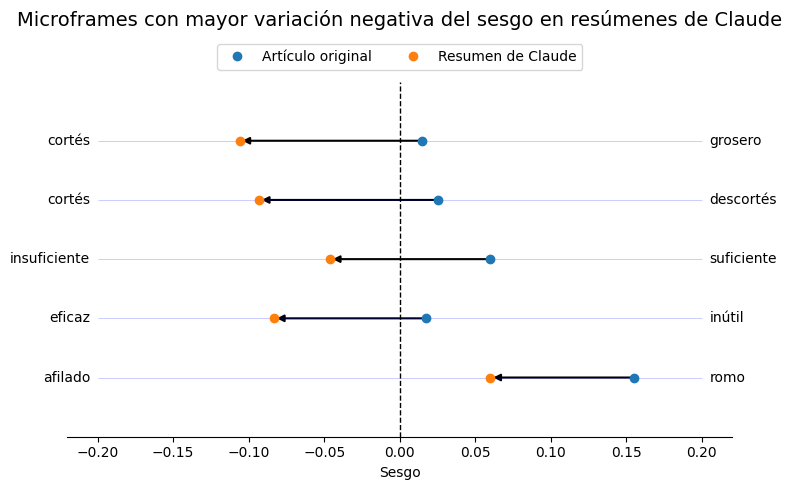

In [296]:
plot_diff(claude_bias_neg, "Claude", "negativa")

### Top 5 variaciones positivas y negativas de la intensidad

In [297]:
claude_intensity_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_claude_summaries.tsv',
    reverse=True,
    n=5
)
claude_intensity_pos

,uri,microframe,diff,body,summary
0,7041620065,"('civil', 'militar')",10.330683,0.001338,0.015161
1,6899009343,"('general', 'local')",7.104830,0.001972,0.015979
2,6979837813,"('fuera', 'seguro')",6.926930,0.001800,0.014268
3,7197405377,"('internacional', 'nacional')",6.568965,0.002144,0.016229
4,b-7067232658,"('general', 'local')",6.290317,0.002150,0.015671


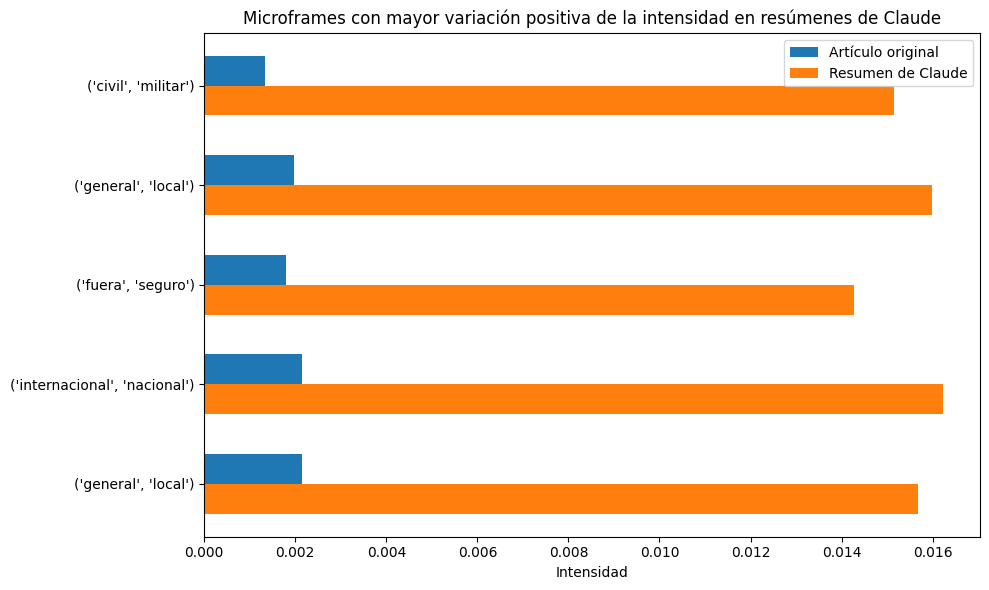

In [298]:
plot_intensity_diff(claude_intensity_pos, "Claude", "positiva")

In [299]:
claude_intensity_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_claude_summaries.tsv',
    reverse=False,
    n=5
)
claude_intensity_neg

,uri,microframe,diff,body,summary
0,6972186557,"('grande', 'menudo')",-0.879042,0.024329,0.002943
1,7112403750,"('gran', 'menudo')",-0.874360,0.017260,0.002169
2,6928703141,"('ningún', 'todo')",-0.862445,0.009646,0.001327
3,7212223049,"('menor', 'principal')",-0.859069,0.012875,0.001814
4,6956559024,"('desconocido', 'sabido')",-0.853590,0.010051,0.001472


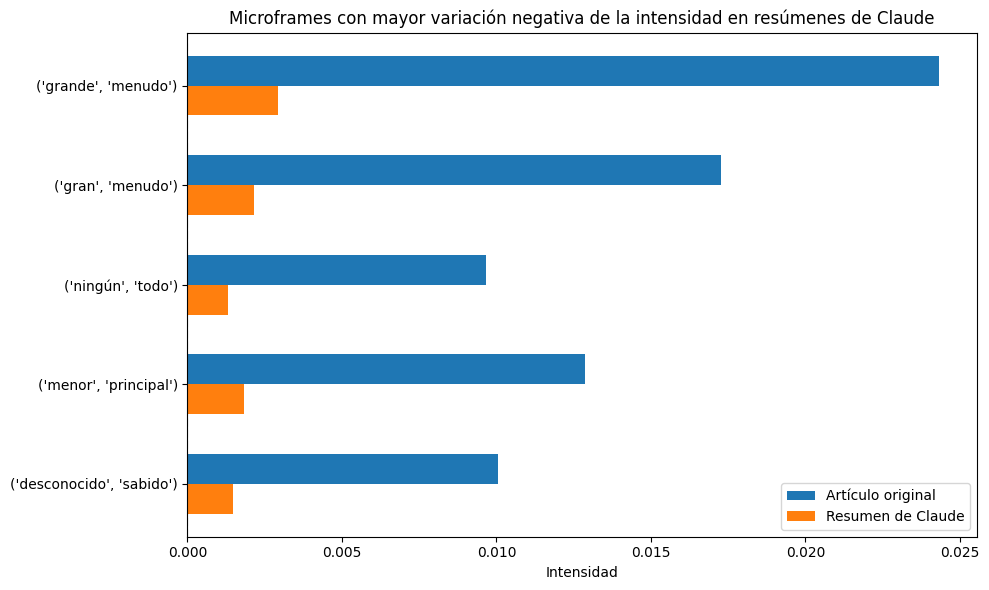

In [300]:
plot_intensity_diff(claude_intensity_neg, "Claude", "negativa")

## Top microframes para los resúmenes generados con Gemini

### Top 5 variaciones positivas y negativas del sesgo

In [301]:
gemini_bias_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_gemini_summaries.tsv',
    reverse=True,
    n=5
)
gemini_bias_pos

,uri,microframe,diff,body,summary
0,7159524639,"('contento', 'descontento')",0.098816,-0.064975,0.033842
1,6920514074,"('diferente', 'equivalente')",0.098146,0.001244,0.099390
2,7271524219,"('desintegrativo', 'integrativo')",0.098139,-0.008966,0.089173
3,7077944209,"('derrochar', 'económico')",0.097453,0.028843,0.126296
4,6920514074,"('inadvertido', 'notable')",0.097371,-0.015143,0.082228


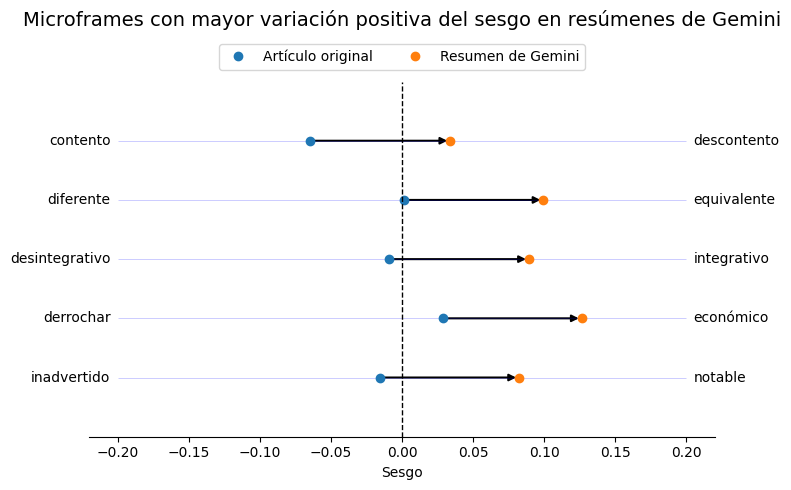

In [302]:
plot_diff(gemini_bias_pos, "Gemini", "positiva")

In [303]:
gemini_bias_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\bias_table_gemini_summaries.tsv',
    reverse=False,
    n=5
)
gemini_bias_neg

,uri,microframe,diff,body,summary
0,6920514074,"('insuficiente', 'suficiente')",-0.111892,-0.031439,-0.143331
1,7297062407,"('cortés', 'grosero')",-0.106160,0.014717,-0.091444
2,6920514074,"('tardío', 'temprano')",-0.105509,0.004763,-0.100746
3,7297062407,"('cortés', 'descortés')",-0.104953,0.025288,-0.079665
4,7161985167,"('insuficiente', 'suficiente')",-0.104863,0.060010,-0.044853


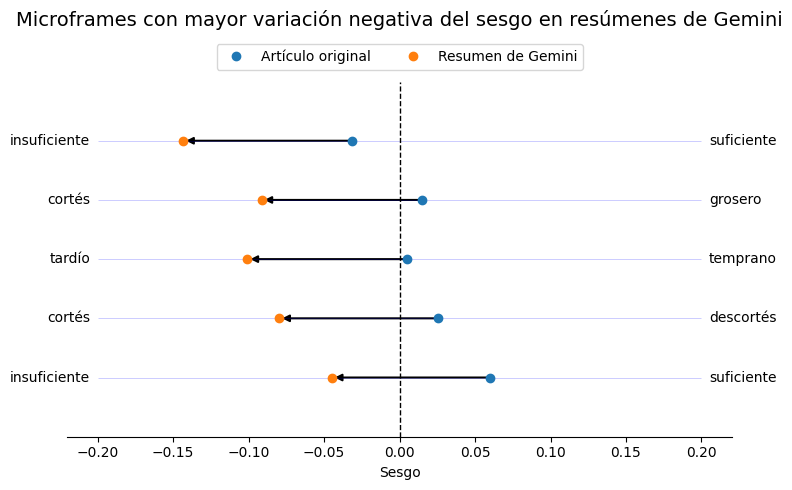

In [304]:
plot_diff(gemini_bias_neg, "Gemini", "negativa")

### Top 5 variaciones positivas y negativas de la intensidad

In [305]:
gemini_intensity_pos = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_gemini_summaries.tsv',
    reverse=True,
    n=5
)
gemini_intensity_pos

,uri,microframe,diff,body,summary
0,7041620065,"('civil', 'militar')",7.866914,0.001338,0.011865
1,7086658262,"('alto', 'corto')",7.416727,0.002369,0.019936
2,7251698175,"('común', 'individual')",7.070291,0.001970,0.015902
3,6920514074,"('comparativo', 'total')",6.756281,0.003080,0.023886
4,6980190730,"('alto', 'bajo')",6.253608,0.002951,0.021408


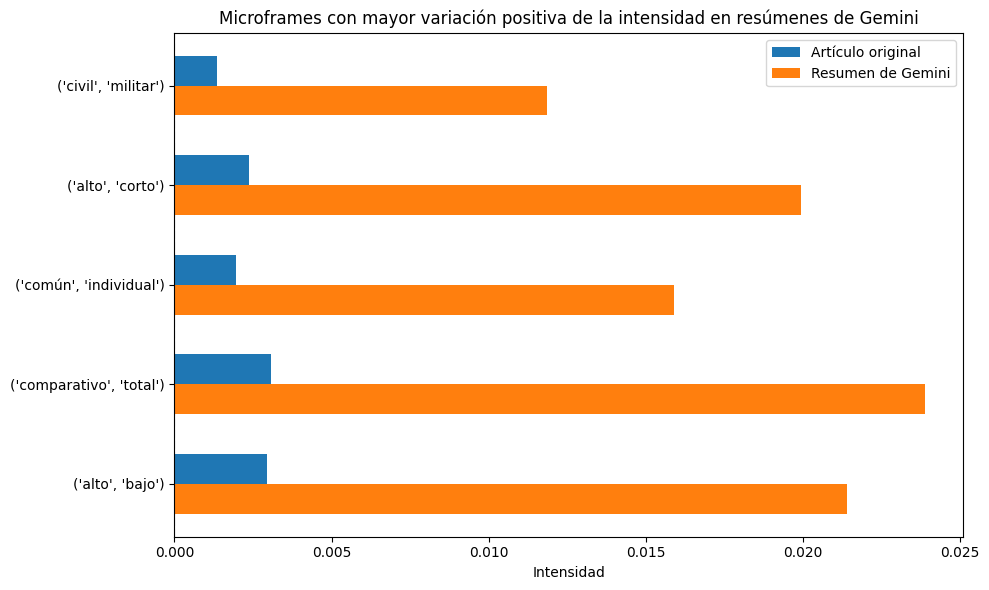

In [306]:
plot_intensity_diff(gemini_intensity_pos, "Gemini", "positiva")

In [307]:
gemini_intensity_neg = top_n_microframe_var(
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_body.tsv',
    r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\results\intensity_table_gemini_summaries.tsv',
    reverse=False,
    n=5
)
gemini_intensity_neg

,uri,microframe,diff,body,summary
0,6928703141,"('ningún', 'todo')",-0.910174,0.009646,0.000866
1,b-7067232658,"('mismo', 'otro')",-0.890479,0.009921,0.001087
2,7159517387,"('alto', 'corto')",-0.882728,0.007098,0.000832
3,7030192869,"('gastado', 'nuevo')",-0.882016,0.013532,0.001597
4,7133036728,"('casto', 'incontinente')",-0.881235,0.009678,0.001149


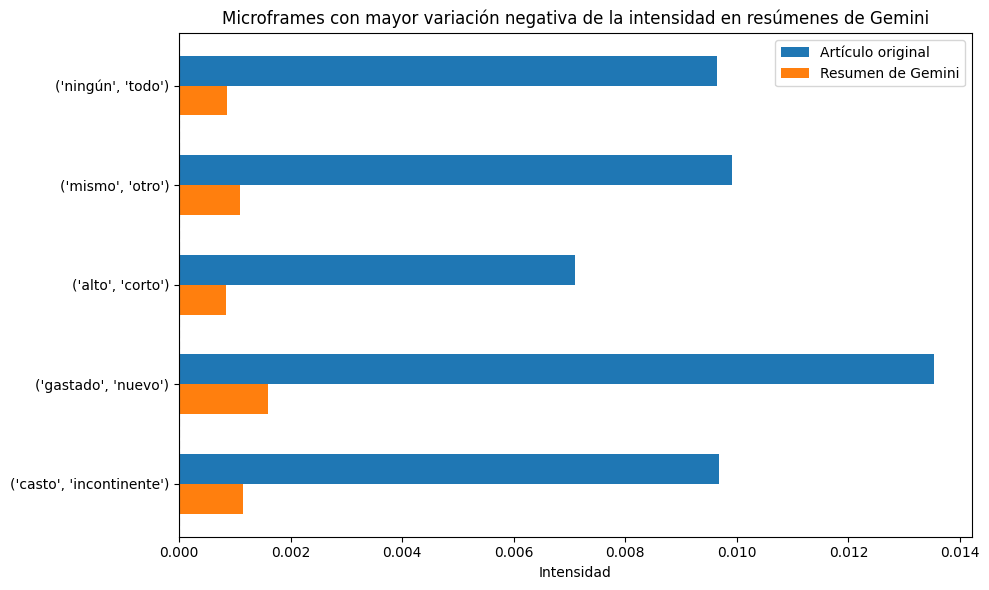

In [308]:
plot_intensity_diff(gemini_intensity_neg, "Gemini", "negativa")

## Palabras con mayor contribución a los microframes con mayor variación

In [309]:
news_df = pd.read_csv(r'C:\Users\fuent\uchile\semestre-10\memoria\frameaxis\chilean-news\dataset\news_sample_with_summaries.csv', dtype={'uri': str})

In [310]:
frameaxis = pickle.load(open('frameaxis_object.p', 'rb'))

### Resúmenes de GPT

In [311]:
def top_word_contributions(top_microframes_df, type, model=None, n=10):
    preprocessed_summary = CoreUtil.preprocess(news_df[news_df['uri'] == top_microframes_df['uri'].loc[0]]['summary'].values[0])
    preprocessed_body = CoreUtil.preprocess(news_df[news_df['uri'] == top_microframes_df['uri'].loc[0]]['body'].values[0])

    if type == 'bias':
        contrib_summary, words_summary = frameaxis.word_contribution(
            [preprocessed_summary], 
            ast.literal_eval(top_microframes_df['microframe'].loc[0]),
            min_freq=1
        )
        contrib_body, words_body = frameaxis.word_contribution(
            [preprocessed_body], 
            ast.literal_eval(top_microframes_df['microframe'].loc[0]),
            min_freq=1
        )

    elif type == 'intensity':
        if model:
            df_corpus = pd.read_csv(f"results/bias_table_{model}_summaries.tsv", sep="\t", dtype={'uri': str})
        else:
            df_corpus = pd.read_csv(f"results/bias_table_body.tsv", sep="\t", dtype={'uri': str})

        # para el microframe a usar promedia el sesgo a lo largo de los textos
        microframe_col = top_microframes_df['microframe'].loc[0]
        corpus_mean = np.mean(df_corpus[microframe_col])

        contrib_summary, words_summary = frameaxis.word_contribution_to_second_moment(
            [preprocessed_summary], 
            ast.literal_eval(top_microframes_df['microframe'].loc[0]),
            corpus_mean,
            min_freq=1
        )
        contrib_body, words_body = frameaxis.word_contribution_to_second_moment(
            [preprocessed_body], 
            ast.literal_eval(top_microframes_df['microframe'].loc[0]),
            corpus_mean,
            min_freq=1
        )

    contrib_summary_df = pd.DataFrame({
        'word': words_summary,
        'contribution': contrib_summary[0][0],
        'abs_contribution': np.abs(contrib_summary[0][0])
    })

    contrib_body_df = pd.DataFrame({
        'word': words_body,
        'contribution': contrib_body[0][0],
        'abs_contribution': np.abs(contrib_body[0][0])
    })

    top_contrib_body = contrib_body_df.sort_values('abs_contribution', ascending=False).reset_index(drop=True).head(n)
    top_contrib_summary = contrib_summary_df.sort_values('abs_contribution', ascending=False).reset_index(drop=True).head(n)

    return top_contrib_body, top_contrib_summary

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


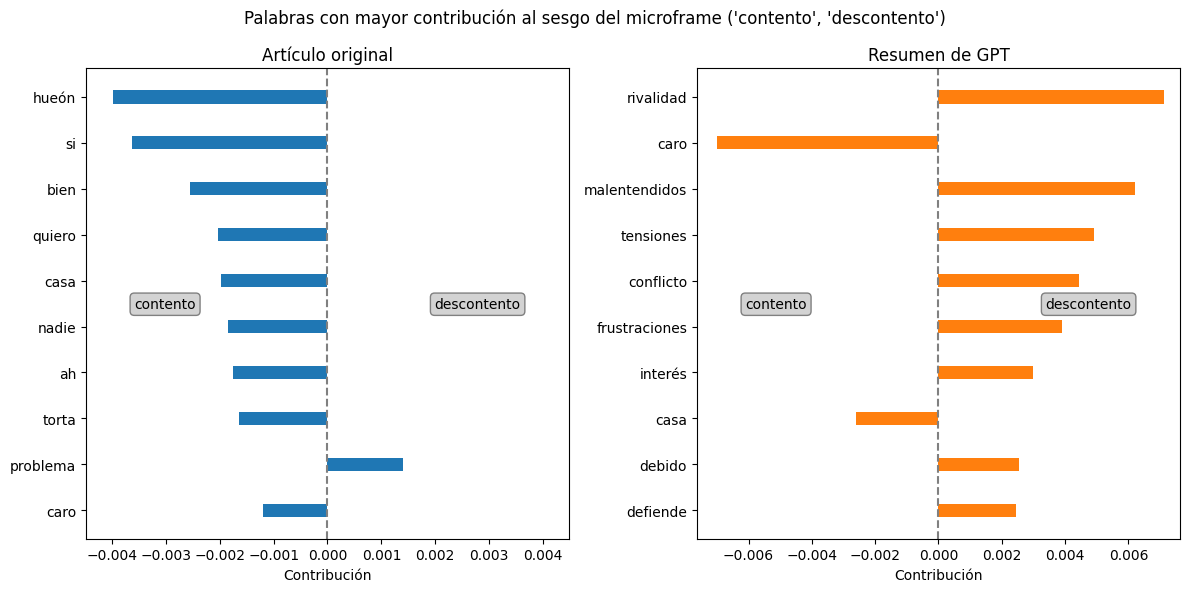

In [312]:
plot_word_contribution(*top_word_contributions(gpt_bias_pos, 'bias', 'gpt', n=10), gpt_bias_pos['microframe'].loc[0], "gpt-bias-pos", 'GPT', 'bias')

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


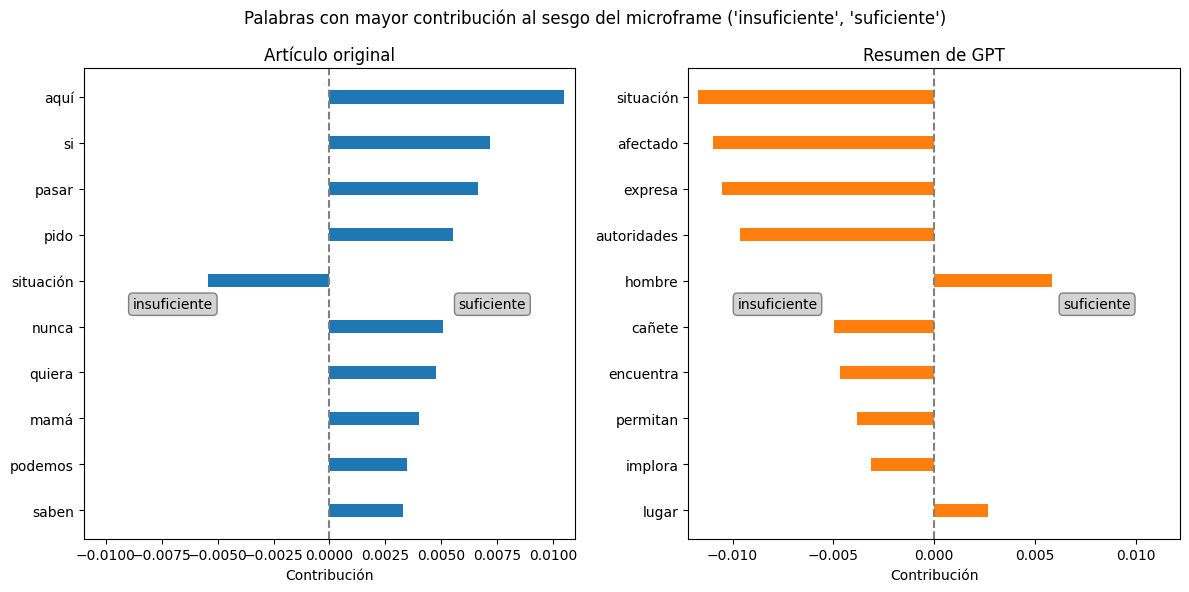

In [313]:
plot_word_contribution(*top_word_contributions(gpt_bias_neg, 'bias', 'gpt', n=10), gpt_bias_neg['microframe'].loc[0], "gpt-bias-neg", 'GPT', 'bias')

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


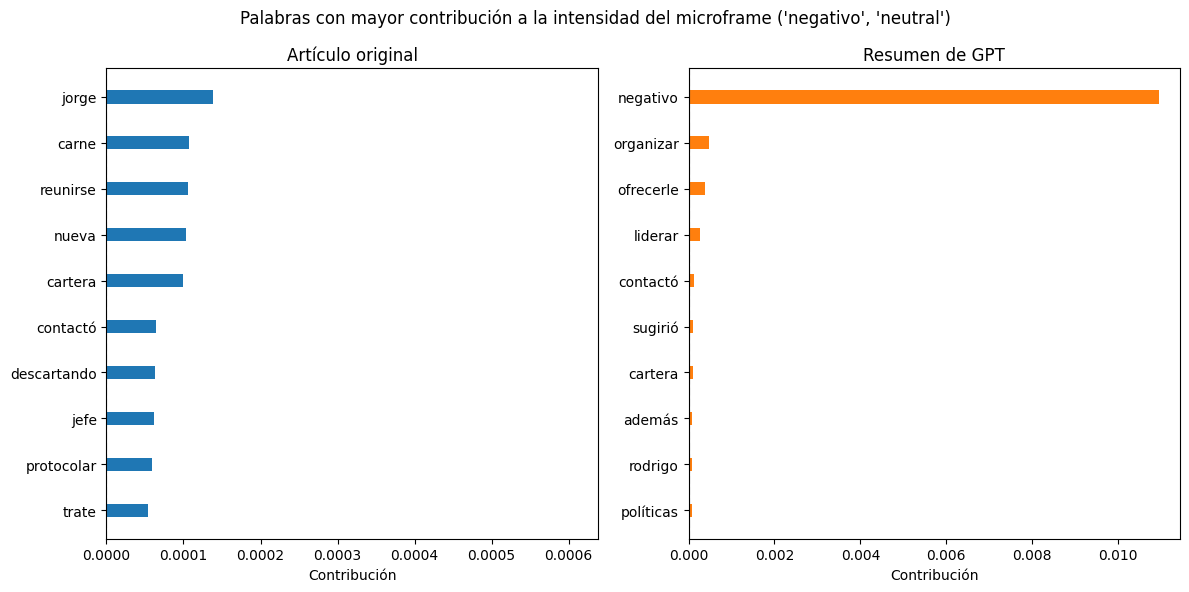

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


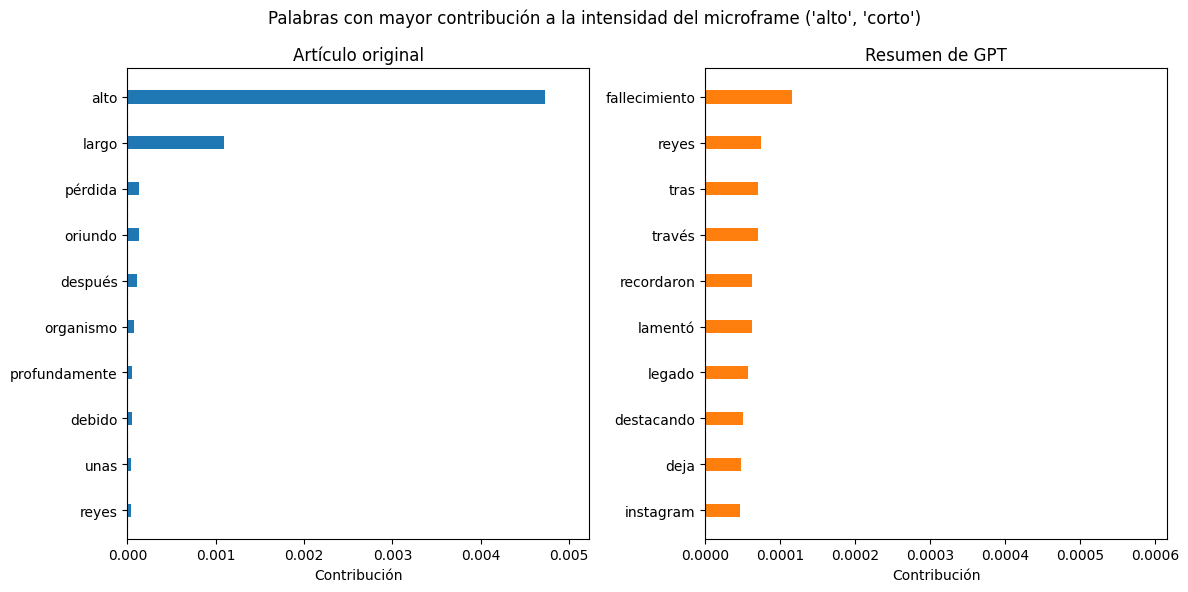

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


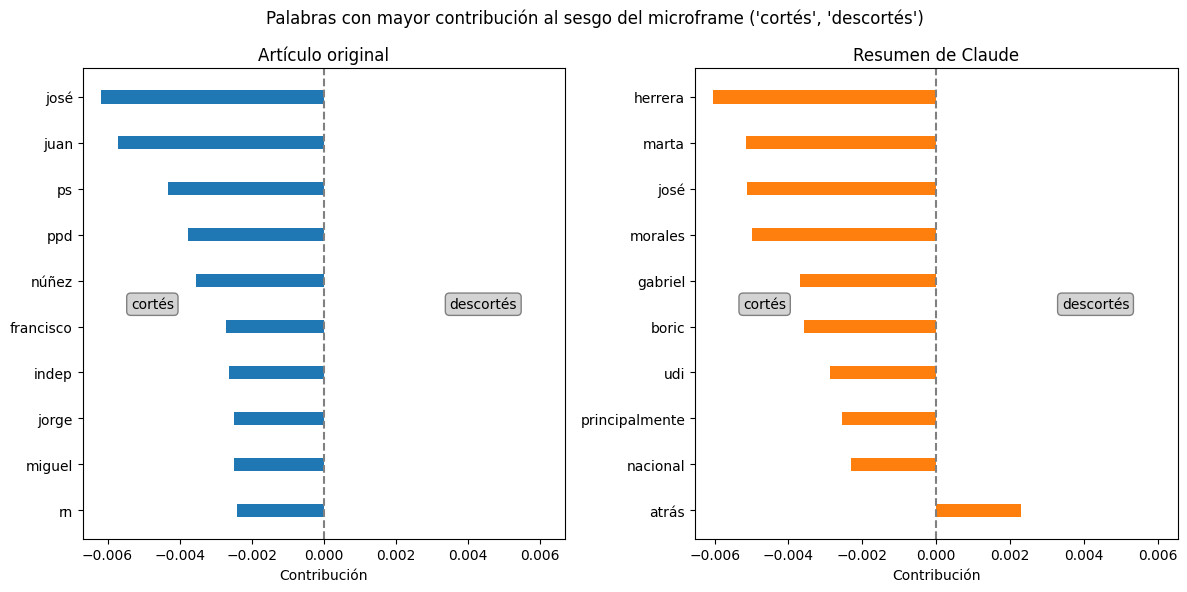

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


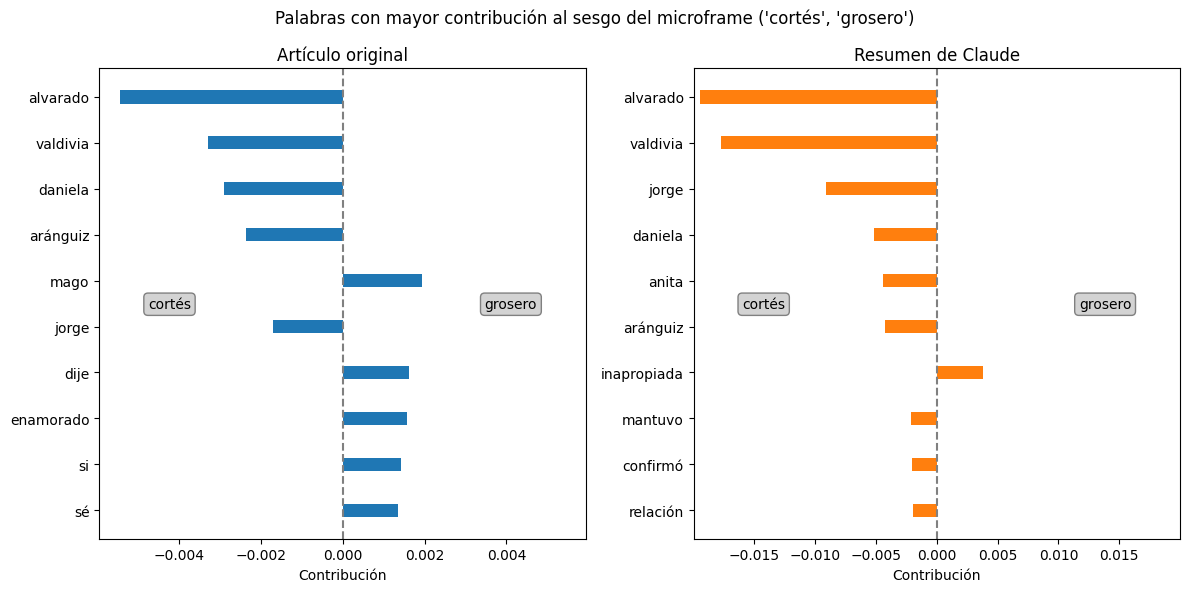

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


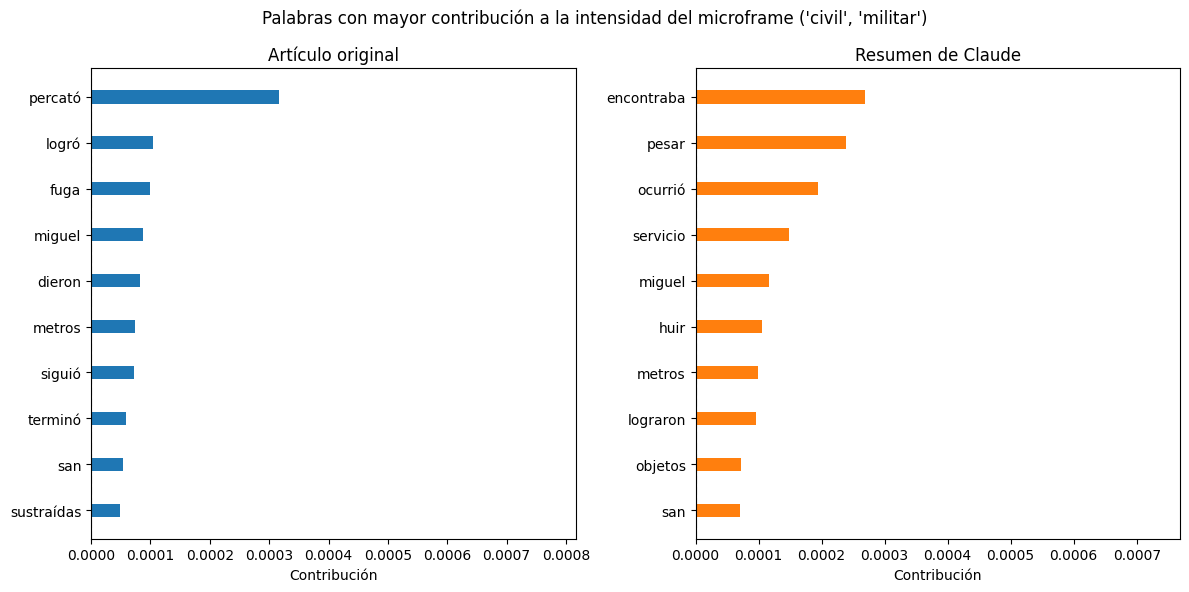

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


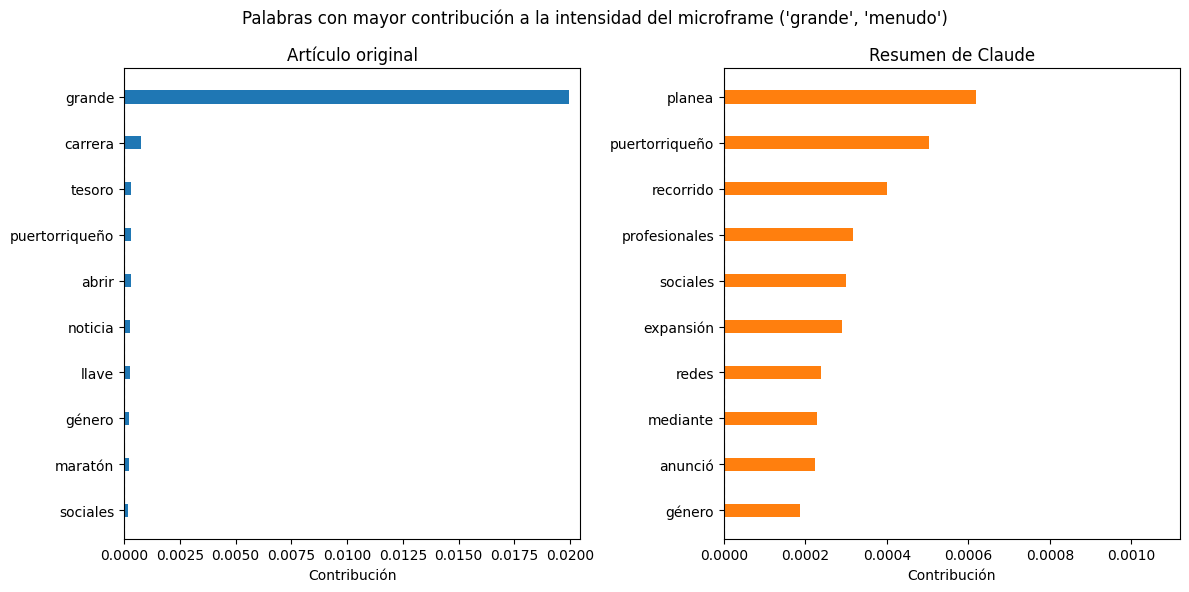

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


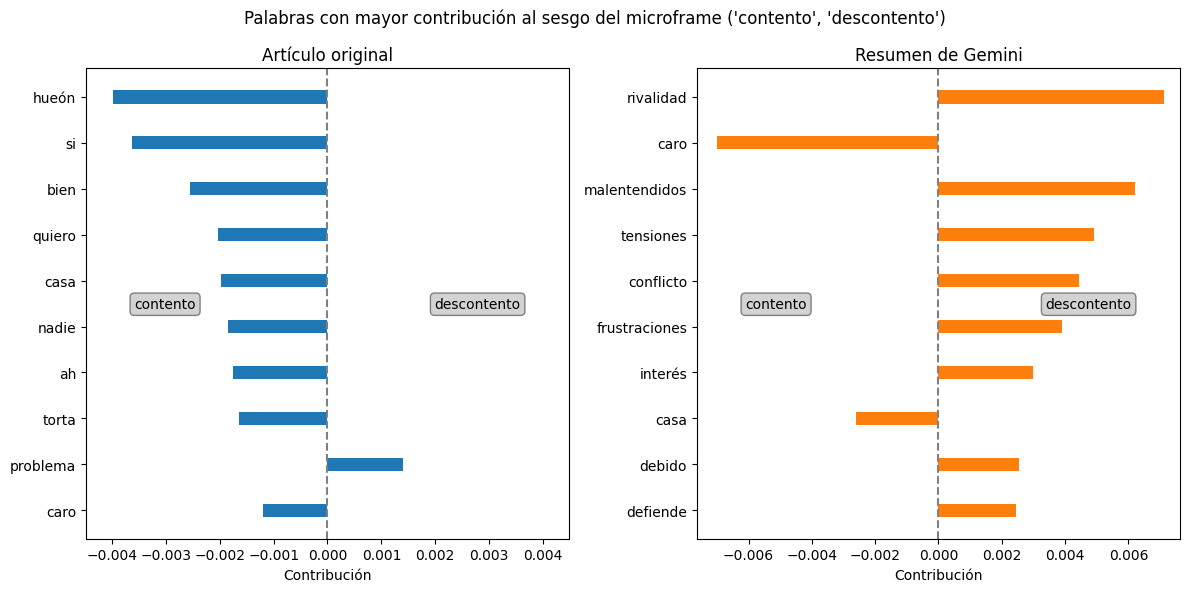

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


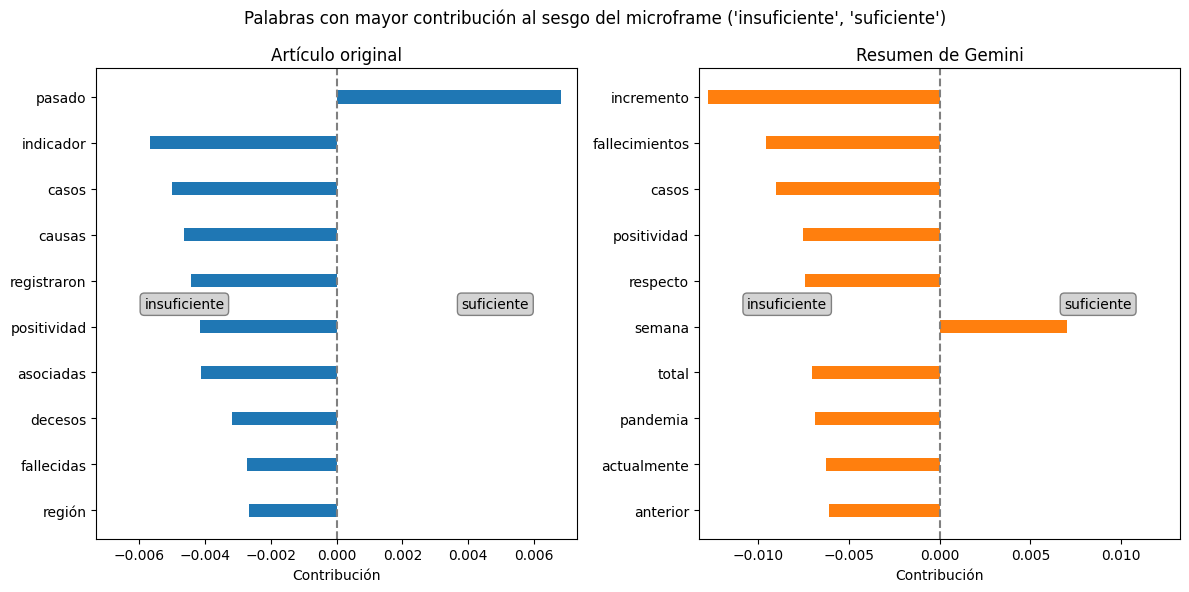

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


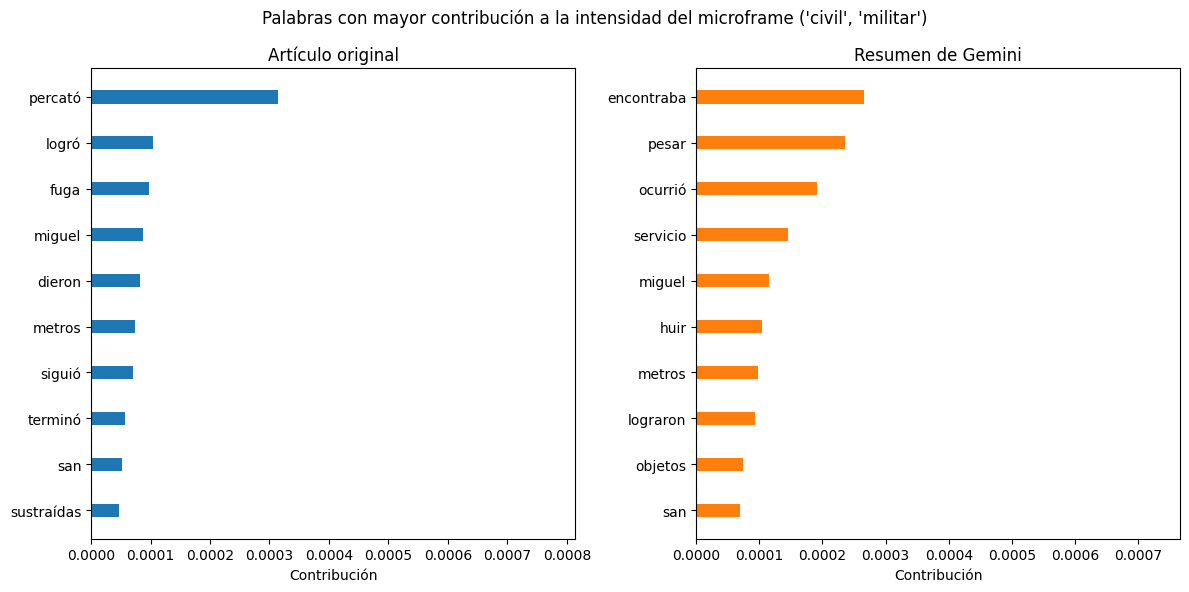

c:\Users\fuent\AppData\Local\pypoetry\Cache\virtualenvs\frameaxis-nVQu9Ozg-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


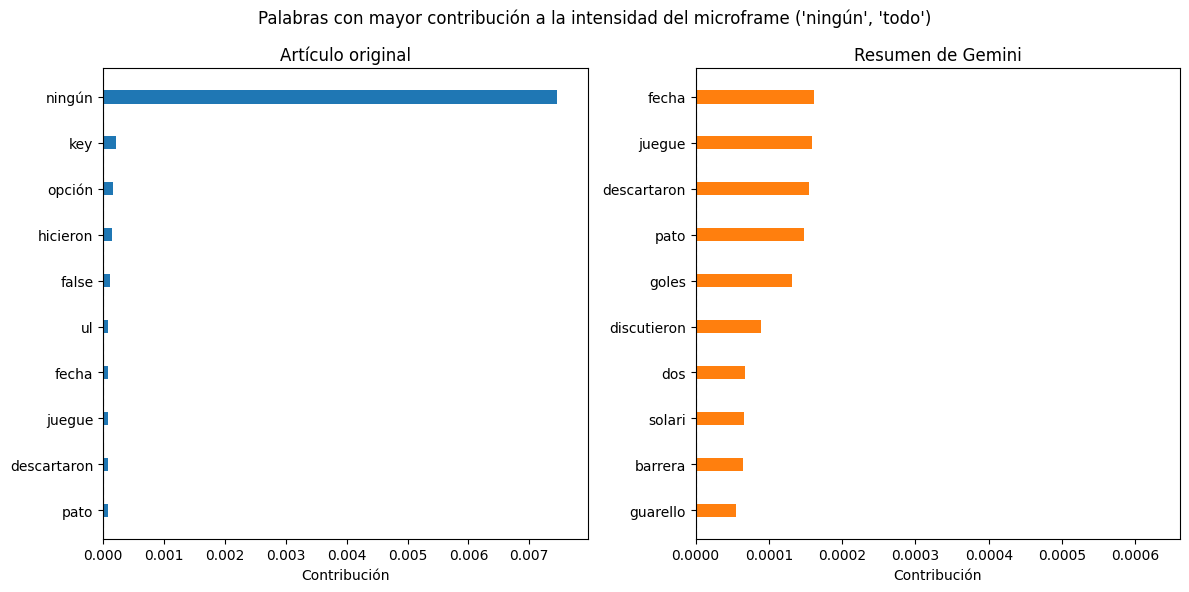

In [314]:

plot_word_contribution(*top_word_contributions(gpt_intensity_pos, 'intensity', 'gpt', n=10), gpt_intensity_pos['microframe'].loc[0], "gpt-intensity-pos", 'GPT', 'intensity')
plot_word_contribution(*top_word_contributions(gpt_intensity_neg, 'intensity', 'gpt', n=10), gpt_intensity_neg['microframe'].loc[0], "gpt-intensity-neg", 'GPT', 'intensity')
plot_word_contribution(*top_word_contributions(claude_bias_pos, 'bias', 'claude', n=10), claude_bias_pos['microframe'].loc[0], "claude-bias-pos", 'Claude', 'bias')
plot_word_contribution(*top_word_contributions(claude_bias_neg, 'bias', 'claude', n=10), claude_bias_neg['microframe'].loc[0], "claude-bias-neg", 'Claude', 'bias')
plot_word_contribution(*top_word_contributions(claude_intensity_pos, 'intensity', 'claude', n=10), claude_intensity_pos['microframe'].loc[0], "claude-intensity-pos", 'Claude', 'intensity')
plot_word_contribution(*top_word_contributions(claude_intensity_neg, 'intensity', 'claude', n=10), claude_intensity_neg['microframe'].loc[0], "claude-intensity-neg", 'Claude', 'intensity')
plot_word_contribution(*top_word_contributions(gemini_bias_pos, 'bias', 'gemini', n=10), gemini_bias_pos['microframe'].loc[0], "gemini-bias-pos", 'Gemini', 'bias')
plot_word_contribution(*top_word_contributions(gemini_bias_neg, 'bias', 'gemini', n=10), gemini_bias_neg['microframe'].loc[0], "gemini-bias-neg", 'Gemini', 'bias')
plot_word_contribution(*top_word_contributions(gemini_intensity_pos, 'intensity', 'gemini', n=10), gemini_intensity_pos['microframe'].loc[0], "gemini-intensity-pos", 'Gemini', 'intensity')
plot_word_contribution(*top_word_contributions(gemini_intensity_neg, 'intensity', 'gemini', n=10), gemini_intensity_neg['microframe'].loc[0], "gemini-intensity-neg", 'Gemini', 'intensity')